In [428]:
from sympy.physics.optics import RayTransferMatrix, ThinLens, BeamParameter, FreeSpace
from sympy import symbols, init_printing, pi, sqrt, pprint, solveset, S, plot, cos, Eq
from scipy.constants import c
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import numpy as np

init_printing()

from ipywidgets.widgets import (
    IntSlider,
    FloatLogSlider,
    FloatSlider,
    interactive_output,
    FloatRangeSlider,
    BoundedFloatText,
    Checkbox,
    HBox,
    VBox,
    IntRangeSlider,
    BoundedIntText,
    Text,
    Button,
    Label,
    Select,
    Layout
)
from IPython.display import display
import datetime, os
from os.path import isdir
from pathlib import Path

Confocal length: $Z_c$, 
Radius of the curvature of beam wave front: 
R(z) and the Beam radius: w(z) are defined such as: 



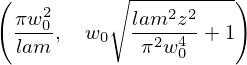

In [429]:
save_location = "D:\SurfDrive\backup_for_surfacePro\Work\THz_setup\Simulations"

w, lam, w0, z = symbols("w, lam, w0, z", positive=True)

# defining the confocal length, R(z) and w(z) in sympy
z_r = pi * w0 ** 2 / lam
#R = z * (1 + (z_r / z) ** 2)
w = w0 * sqrt(1 + (z / z_r) ** 2)



# Defining functions
def ghz_cm(x):
    return c * 1e2 / x * 1e-9


print(\
    "Confocal length: $Z_c$, \
\nRadius of the curvature of beam wave front: \
\nR(z) and the Beam radius: w(z) are defined such as: \n"
)

z_r, w

# Simulating Gaussian beam propagation from inside FELion Trap

We will try to obtain the optimum conditions such the waist radius w0 and distance to the w0 from outside mirror, etc.

In [643]:
class gaussian_simulation:
    def __init__(self):

        W = BoundedFloatText(value=0.3, min=0.1, max=1, step=0.01, description="w0:")
        L = IntRangeSlider(
            value=[400, 1100], min=100, max=1500, step=1, description="GHz"
        )
        
        width = BoundedIntText(value=7, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=5, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=200, min=70, max=250, step=1, description="Dpi")

        entry1 = BoundedFloatText(
            value=-9, min=-11, max=10, step=0.1, description="Entry1"
        )
        Mirror = BoundedIntText(value=11, min=10, max=20, step=1, description="Mirror Position")
        
        self.save_name = Text(value="")

        save_button = Button(description="Save", layout={"width": "300px"})

        save_button.on_click(self.save_plot)

        self.print_save = Label(value="Status: ")

        row1 = HBox([W, L])
        row2 = HBox([width, height, dpi])
        row3 = HBox([entry1, Mirror])

        out = interactive_output(
            self.simulate,
            {
                "w0_": W,
                "wn": L,
                "width": width,
                "height": height,
                "dpi": dpi,
                "entry1": entry1,
                "mirror":Mirror
            },
        )

        display(
            VBox(
                [row1, row2, row3, out, self.save_name, save_button, self.print_save]
            )
        )

    def save_plot(self, event):
        if not isdir('./Simulations'):
            os.mkdir('./Simulations')

        self.fig0.savefig(f"./Simulations/{self.save_name.value}.png")
        self.fig0.savefig(f"./Simulations/{self.save_name.value}.pdf")

        t = datetime.datetime.now()
        self.print_save.value = f'File "{self.save_name.value}.png" Saved; {t.ctime()}'

    def beam_plot(self, ax, w0_, wn):
               
        self.gaussian_beam(w0_, wn)
        
        markers = '--'
        line_width = 1
        alpha = 0.7

        for c, beam in enumerate(self.beams):
            color = f"C{c}"
            ax.plot(
                z_,
                beam,
                markers+color, lw=line_width, alpha=alpha,
                label=f"{self.wn[c]:.2f} GHz ({ghz_cm(self.wn[c])*10:.2f} mm)",
                zorder=1
            )
            ax.plot(-z_, -beam, markers+color, lw=line_width, alpha=alpha, zorder=1)
            ax.plot(-z_, beam, markers+color, lw=line_width, alpha=alpha, zorder=1)
            ax.plot(z_, -beam, markers+color, lw=line_width, alpha=alpha, zorder=1)

    def simulate(self, w0_, wn, width, height, dpi, entry1, mirror):
        
        entry1 = round(entry1, 1)
        entry2 = round(10.4 - abs(entry1), 1)

        self.fig0, ax0 = plt.subplots(figsize=(width, height), dpi=dpi)
        self.beam_plot(ax0, w0_, wn)

        ax0.hlines(0, xmin=-z_.max(), xmax=z_.max())

        ## Annotation begins
        
        fontsz = 6

        # Distance b/w two entry points
        ax0.hlines(-0.2, xmin=entry1, xmax=entry2)
        plt.annotate(
            s=f"d={(entry2-entry1)}",
            xy=(0, 0),
            xytext=(-3, -0.1),
            ha="center",
            va="center",
            fontsize=fontsz
        )

        # Annotate beam waist
        ax0.vlines(x=0, ymin=0, ymax=w0_)
        plt.annotate(
            s="$w_0^{in}$=%.2f cm"%w0_,
            xy=(0, w0_+0.2),
            xytext=(0, 0.8),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )

        # Annotate Entry1
        ax0.vlines(x=entry1, ymin=-1, ymax=1)

        plt.annotate(
            s="Main entry window:\ndiameter=2cm",
            xy=(entry1, 1),
            xytext=(entry1 + 6, 1.1),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )

        # Annotate Entry2
        ax0.vlines(x=entry2, ymin=-0.43, ymax=0.43)

        plt.annotate(
            s="Trap bender entry:\ndiameter=0.86cm",
            xy=(entry2, -0.43),
            xytext=(entry2 - 3, -0.8),
            ha="center",
            va="center",
            # rotation = 30,
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )
        
        # Inner entry: diameter: 0.64cm
        ax0.vlines(x=entry2+0.7, ymin=-0.32, ymax=0.32)

        # Annotate z-position

        plt.annotate(s="z=0", xy=(0, 0), xytext=(0, -0.05), ha="center", va="center",fontsize=fontsz)

        plt.annotate(
            s=f"z={entry1}",
            xy=(entry1, 0),
            xytext=(entry1 - 2, -0.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )
        
        # d_in window
        mirror_pos = entry1-mirror
        ax0.vlines(x=mirror_pos, ymin=-self.beams.max(), ymax=self.beams.max())
        
        plt.annotate(
            s="Mirror($d_{in}$) at %.1f cm"%mirror_pos,
            xy=(mirror_pos+5, -self.beams.max()),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            fontsize=fontsz
        )

        ## Annotation ends

        ax0.set_xlabel("z direction : Beam Propagation (cm)")
        ax0.set_ylabel("w(z) : Gaussian Beam radius (cm)")
        ax0.set_title(f"Gaussian Beam simulation: {wn[0]}-{wn[-1]} GHz")
        ax0.legend(bbox_to_anchor=(0.16, 0.86), ncol=3, fontsize=5)
        ax0.xaxis.set_minor_locator(AutoMinorLocator())
        
        plt.show()
        # plt.close()

        self.save_name.value = f"{w0_}cm-{wn[0]}-{wn[-1]}GHz_simulation"

    def gaussian_beam(self, w0_, wn):

        global w, z_
        
        # Defining the z-propagation range
        z_ = np.linspace(0, 25, 10)

        self.wn = np.linspace(*wn, 10)

        beam = []
        beams = []

        for l in self.wn:

            temp = []
            beam = []

            for i in z_:
                temp = float(w.subs({w0: w0_, lam: ghz_cm(l), z: i}).evalf())
                beam.append(temp)
            beams.append(beam)

        self.beams = np.array(beams)
#%matplotlib widget
%matplotlib inline
start = gaussian_simulation()

# Ellipsoidal mirror (Goldsmith, 1998)

An ellipsoidal mirror in the geometrical optics limit, transforms radiation from a point source at one focal point to a point source located at the second focal point; this is true for any part of the ellipsoidal surface of revolution,
formed by rotating the ellipse about the line joining its foci. 

First consider a lens that has a focal length equal to the distance from the first focal point to the center of the part of the ellipsoidal surface being used (R1). 
This lens will collimate the radiation from the first focal point into a parallel beam. 

If we immediately follow this first lens by a second, having focal length equal to the distance from the center of the mirror to the second focal point (R2) , the second lens will bring the parallel beam to a focus at the desired position. 



## Thin lens
ABCD matrix for thin lens of focal length $f_{lens}$

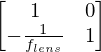

In [4]:
f_lens = symbols('f_lens')
M_lens = ThinLens(f_lens)
M_lens

## Elliptical mirror effective focal length

Thus, the ABCD matrix for an ellipsoidal mirror is the product of two matrices, each representing a thin lens, and having zero separation:
where R1 and R2 are the distances from the center of the section of the ellipsoid used to the respective foci

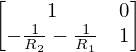

In [5]:
R1, R2 = symbols('R1, R2')
M_l1 = ThinLens(R1)
M_l2 = ThinLens(R2)
M_d = FreeSpace(0)
M_ellipsoid = M_l2*M_d*M_l1
M_ellipsoid

So that comparing with the expression for the thin lens, we see that the Effective focal length of an elliptical mirror: f_ellipsoid is given by

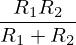

In [6]:
f_ellipsoid = 1/(1/R1+1/R2)
print('\n')
f_ellipsoid.simplify()

# Mode Matching (Goldsmith 1998)

Quasioptical system designers are often required to couple the power in a beam (e.g., that produced by a feed hom) to a specified beam waist radius (e.g., that required by some component in a receiver system). Dealing with beam transformation from this perspective is often called mode matching

## Case 1:
In practice most often the case is: We are given the input and output waist radii, and thus the magnification, together with the input distance. Solving for the required focal length, we obtain

In [7]:
M, E, d_in, d_out, w0_in, w0_out, Z_c = symbols('M, E, d_in, d_out, w0_in, w0_out, Z_c')

fp = Z_c*(d_in/(E*Z_c))*(1+sqrt(1-E*(1+(d_in/Z_c)**-2)))
fm = Z_c*(d_in/(E*Z_c))*(1-sqrt(1-E*(1+(d_in/Z_c)**-2)))

Positive and negative focus "f" for M>1

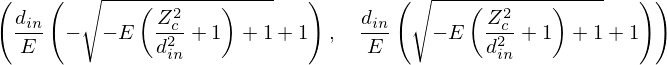

In [8]:
fm, fp

For M=1
Focus is given by:


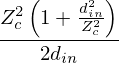

In [9]:
f1 = Z_c*(1+(d_in/Z_c)**2)/(2*d_in/Z_c)
print('For M=1\nFocus is given by:')
f1

Assuming for the case of our ellipse, 
$$d_{in} = R1$$  $$f = f_{ellipsoid}$$ 

we can solve for R2 i.e., $d_{out}$


The eccentricity can also be defined in terms of R1, R2, and the angle α between input and output beams (Goldsmith, 1998)

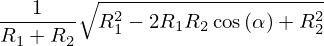

In [10]:
alpha = symbols('alpha')
e_ellipsoid = sqrt(R1**2 + R2**2 - 2*R1*R2*cos(alpha))/(R1 + R2)
e_ellipsoid

Eccentricity of an elliptical mirror is already defined as :



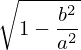

In [11]:
a, b = symbols('a, b')
print('Eccentricity of an elliptical mirror is already defined as :\n')

e_standard = sqrt(1-b**2/a**2)
e_standard

where a and b are the semi-major and semi-minor axis respectivey.

The semi-major axis a is also defined as: 



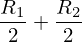

In [12]:
print('The semi-major axis a is also defined as: \n')
a = (R1 + R2)/2
a

In [13]:
class f_soln:
    def __init__(self):
        mag = BoundedFloatText(
            value=0.41, min=0.1, max=10, step=0.01, description="M: "
        )
        W = BoundedFloatText(
            value=0.34, min=0.1, max=1, step=0.01, description="w0_in: "
        )
        R1 = BoundedFloatText(value=18, min=5, max=20, step=0.1, description="R1: ")
        L = IntRangeSlider(
            value=[325, 500], min=50, max=1500, step=1, description="GHz"
        )

        width = BoundedIntText(value=10, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=6, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=100, min=70, max=250, step=1, description="Dpi")

        self.save_name = Text(value="")

        save_button = Button(description="Save", layout={"width": "300px"})

        save_button.on_click(self.save_plot)

        self.print_save = Label(value="Status: ")

        row1 = HBox([width, height, dpi])
        row2 = HBox([mag, W, R1, L])

        out = interactive_output(
            self.plot,
            {
                "M": mag,
                "r1": R1,
                "w0_in": W,
                "lam": L,
                "width": width,
                "height": height,
                "dpi": dpi,
            },
        )

        display(VBox([row1, row2, out, self.save_name, save_button, self.print_save]))

    def plot(self, M, r1, w0_in, lam, width, height, dpi):

        wn = np.linspace(*lam, 50)

        x, y1, y2 = [], [], []
        no_soln, soln = [], []
        for l in wn:
            zc = np.pi * w0_in ** 2 / ghz_cm(l)

            temp0 = r1 / zc
            x.append(temp0)

            try:

                if not M == 1:
                    temp1 = fm / zc
                    temp1_1 = float(
                        temp1.subs({E: 1 - M ** -2, d_in: r1, Z_c: zc}).evalf()
                    )
                elif M == 1:
                    temp1 = f1 / Zc
                    temp1_1 = float(temp1.subs({d_in: r1, Z_c: zc}).evalf())

                y1.append(temp1_1)
                soln.append(round(l, 2))
            except:
                no_soln.append(round(l, 2))

        self.fig, axs = plt.subplots(figsize=(width, height), dpi=dpi)

        x_ = x[: len(y1)]
        axs.plot(x_, y1, color='C0', label=f"f/$Z_c$; $w0(trap)$={w0_in}cm;" + "$d_{in}$=%.2f cm" % r1,)
        
        axs.legend()
        axs.grid()
        axs.set_xlabel("$d_{in}$/$Z_c$")
        axs.set_ylabel("f/$Z_c$", color='C0')
        axs.set_title(
            f"For M={M}: Solution exist for {soln[0]}-{soln[-1]} GHz"
        )
        axs.tick_params(axis='y', labelcolor='C0')
        
        
        if len(no_soln) > 0 and len(soln) > 0:
            print(f"\nSolution: Exists for {soln[0]}-{soln[-1]} GHz\n")

            print(f"Does not exist for: {no_soln[0]}-{no_soln[-1]} GHz\n")
        if len(soln) < 1:
            print(f"x: {x}\ny: {y1}")

        # Finding R2 position:
        x_ = np.array(x_)
        y1 = np.array(y1)
        r2 = r1 / ((x_ / y1) - 1)
        r2_ind = np.logical_and(r2 <= 50, r2 > 0)
        
        axs1 = axs.twinx()
        axs1.plot(x_[r2_ind], r2[r2_ind], color='C1', label="$d_{out}$")
        
        axs1.set_ylabel('$d_{out}$ (cm)', color='C1')
        axs1.tick_params(axis='y', labelcolor='C1')
        axs1.legend()
        
        #self.fig.legend()
        
        try:
            self.save_name.value = f"M-{M}_{soln[0]}-{soln[-1]}GHz_din_{r1}cm"
        except:
            pass
        plt.show()

    def save_plot(self, event):

        self.fig.savefig(f"./{self.save_name.value}.png")

        t = datetime.datetime.now()
        self.print_save.value = f'File "{self.save_name.value}.png" Saved; {t.ctime()}'

## Simulation to determine optimal focal length solution for elliptical mirror.

In [14]:
start = f_soln()

The above simulation shows that we might need different focal length R2 for different wavelength, so we cannot use this method. Let us examine another case as defined below.

## Case 2:

The input and output distance to waist is a fixed sum d, then the expression for input and output distance is given by:

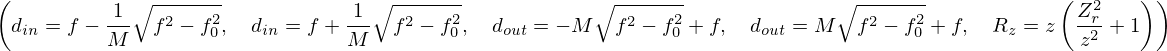

In [574]:
f, f0, d, M, d_in, d_out, R_z, Z_r = symbols("f, f0, d, M, d_in, d_out, R_z, Z_r")

eq_din_m = Eq(d_in, f - sqrt(f ** 2 - f0 ** 2) / M)
eq_din_p = Eq(d_in, f + sqrt(f ** 2 - f0 ** 2) / M)

eq_dout_m = Eq(d_out, f - sqrt(f ** 2 - f0 ** 2) * M)
eq_dout_p = Eq(d_out, f + sqrt(f ** 2 - f0 ** 2) * M)

eq_radiusOfCurvature = Eq(R_z, z*(1+(Z_r/z)**2))

eq_din_m, eq_din_p, eq_dout_m, eq_dout_p, eq_radiusOfCurvature

We will now try to find the focal length for an optimal d_out corresponds to M (which provides w_out since we already know w_in) using the known set d_in value (from trap) and 
$$f0 = \pi*(w0_{in}*w0_{out})/\lambda$$

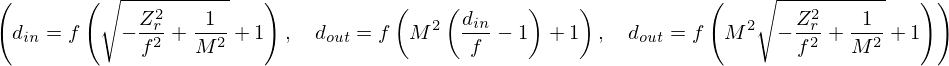

In [579]:
eq_dout2 = Eq(d_out, f * (1 + (M ** 2 * (d_in / f - 1))))
eq_din2 = Eq(d_in, f * (1 + sqrt(M ** -2 - (Z_r / f) ** 2)))
eq_din2, eq_dout2, eq_dout2.subs({d_in:eq_din2.rhs})

In [707]:
class f_case2:
    def __init__(self):

        # Beam properties
        Win = BoundedFloatText(
            value=0.34, min=0.1, max=1, step=0.01, description="$w0_{in}$: "
        )
        Wout = BoundedFloatText(
            value=0.15, min=0.01, max=1, step=0.01, description="$w0_{out}$: "
        )
        D1 = BoundedFloatText(
            value=20, min=5, max=30, step=0.1, description="$d_{in}$: "
        )
        L = IntRangeSlider(
            value=[325, 500], min=50, max=1500, step=1, description="GHz"
        )

        # subplot adjust
        plot0_top = BoundedFloatText(
            value=0.79, min=0, max=1, step=0.01, description="top-sub"
        )
        plot0_bottom = BoundedFloatText(
            value=0.1, min=0, max=1, step=0.01, description="bottom-sub"
        )
        plot0_left = BoundedFloatText(
            value=0.1, min=0, max=1, step=0.01, description="left-sub"
        )
        plot0_right = BoundedFloatText(
            value=0.9, min=0, max=1, step=0.01, description="right-sub"
        )
        plot0_wspace = BoundedFloatText(
            value=0.34, min=0, max=1, step=0.01, description="wspace-sub"
        )

        # Legend label adjust
        Lg_X = BoundedFloatText(value=0.2, min=0.1, max=2, step=0.1, description="lg_x")
        Lg_Y = BoundedFloatText(value=0.8, min=0, max=2, step=0.1, description="lg_y")
        Lg_X1 = BoundedFloatText(value=1, min=0.1, max=2, step=0.1, description="lg_x")
        Lg_Y1 = BoundedFloatText(value=1, min=0, max=2, step=0.1, description="lg_y")

        # Figure property adjust
        width = BoundedIntText(value=15, min=5, max=25, step=1, description="width")
        height = BoundedIntText(value=6, min=5, max=25, step=1, description="height")
        dpi = BoundedIntText(value=100, min=70, max=300, step=1, description="Dpi")

        # Figure Label adjust
        Xlabel = Text(value="Frequency (GHz)")
        Ylabel_0 = Text(value=" + ve f (cm)")
        Ylabel_1 = Text(value=" - ve f (cm)")
        Title = Text(
            value="Determining focal length (f) from given M and $d_{in}$ then calculating $d_{out}$"
        )

        # Widget to save plot1
        self.save_name = Text(value="")
        save_button = Button(description="Save", layout={"width": "300px"})
        save_button.on_click(self.save_plot)
        self.print_save = Label(value="Status: ")

        # Plot 2 widgets
        self.focal_list1 = Select(
            options=["1"],
            description="+ve F:",
            layout=Layout(width="30%", height="160px"),
        )
        self.focal_list2 = Select(
            options=["2"],
            description="-ve F:",
            layout=Layout(width="30%", height="160px"),
        )
        custom = Checkbox(value=True, description="f-Auto")
        f1 = BoundedFloatText(value=5, min=1, max=25, step=0.1, description="f (+ve) ")
        f2 = BoundedFloatText(
            value=-15, min=-25, max=-1, step=0.1, description="f(-ve): "
        )
        Alpha = BoundedFloatText(
            value=90, min=0, max=360, step=1, description=r"2\(\theta\)"
        )

        # Widget to save plot2

        self.save_name1 = Text(value="")
        save_button1 = Button(description="Save", layout={"width": "300px"})
        save_button1.on_click(self.save_plot1)
        self.print_save1 = Label(value="Status: ")

        # Making interactive outputs
        out = interactive_output(
            self.plot,
            {
                "d1": D1,
                "w0_in": Win,
                "w0_out": Wout,
                "lam": L,
                "width": width,
                "height": height,
                "dpi": dpi,
                "xlabel": Xlabel,
                "ylabel_0": Ylabel_0,
                "ylabel_1": Ylabel_1,
                "title": Title,
                "lg_x": Lg_X,
                "lg_y": Lg_Y,
                "top": plot0_top,
                "bottom": plot0_bottom,
                "left": plot0_left,
                "right": plot0_right,
                "wspace": plot0_wspace,
            },
        )
        out1 = interactive_output(
            self.plot2,
            {
                "focal_list1": self.focal_list1,
                "focal_list2": self.focal_list2,
                "d1": D1,
                "width": width,
                "height": height,
                "dpi": dpi,
                "lam": L,
                "w0_in": Win,
                "w0_out": Wout,
                "lg_x": Lg_X1,
                "lg_y": Lg_Y1,
                "f_auto": custom,
                "f_manual1": f1,
                "f_manual2": f2,
                "theta": Alpha,
            },
        )

        # Widget to save plot3
        self.save_name2 = Text(value="")
        save_button2 = Button(description="Save", layout={"width": "300px"})
        save_button2.on_click(self.save_plot2)
        self.print_save2 = Label(value="Status: ")

        out2 = interactive_output(
            self.new_beams_fn,
            {
                "f_auto": custom,
                "focal_list1": self.focal_list1,
                "focal_list2": self.focal_list2,
                "f_manual1": f1,
                "f_manual2": f2,
                "win_new": Win,
                "d_in": D1,
                "width": width,
                "height": height,
                "dpi": dpi,
            },
        )

        # Alignment of widgets
        row1 = HBox([width, height, dpi])
        row2 = HBox([Win, Wout, D1, L])
        row3 = HBox([Xlabel, VBox([Ylabel_0, Ylabel_1]), Title])
        row4 = HBox([out])
        row5 = HBox(
            [
                Lg_X,
                Lg_Y,
                VBox([plot0_top, plot0_bottom, plot0_left, plot0_right, plot0_wspace]),
            ]
        )
        row6 = VBox([self.save_name, save_button, self.print_save])
        row7 = HBox([self.focal_list1, self.focal_list2])
        row8 = HBox([out1])
        row9 = HBox([Lg_X1, Lg_Y1])
        row10 = HBox([VBox([self.save_name1, save_button1, self.print_save1]), VBox([custom, f1, f2, Alpha])])
        row11 = VBox([out2])
        row12 = VBox([self.save_name2, save_button2, self.print_save2])

        display(
            VBox(
                [
                    row1,
                    row2,
                    row3,
                    row4,
                    row5,
                    row6,
                    row7,
                    row8,
                    row9,
                    row10,
                    row11,
                    row12,
                ]
            )
        )

    def plot(
        self,
        d1,
        w0_in,
        w0_out,
        lam,
        width,
        height,
        dpi,
        xlabel,
        ylabel_0,
        ylabel_1,
        title,
        lg_x,
        lg_y,
        top,
        bottom,
        left,
        right,
        wspace,
    ):

        M_ = w0_out / w0_in
        lam = np.linspace(*lam, 10)

        f0_ = []
        f_m, f_p = [], []
        d_out_m, d_out_p = [], []
        no_soln, soln = [], []

        freq = []

        for l in lam:
            tempx = (np.pi * w0_in * w0_out) / ghz_cm(l)

            try:
                f0_.append(tempx)
                tempy = solveset(
                    eq_din_p.subs({M: M_, d_in: d1, f0: tempx}), f
                )  # find focal length, f,  from d_in (+ve) equation

                tempy_m = float(tempy.args[0])  # Negative f
                tempy_p = float(tempy.args[1])  # Positive f

                f_m.append(tempy_m)
                f_p.append(tempy_p)

                temp_dout_m = float(
                    eq_dout_p.subs({M: M_, f: tempy_m, f0: tempx}).rhs
                )  # finding d_out (equation corresponds to same sign as d_in: +ve) from the calculated -ve f
                temp_dout_p = float(
                    eq_dout_p.subs({M: M_, f: tempy_p, f0: tempx}).rhs
                )  # finding d_out (equation corresponds to same sign as d_in: +ve) from the calculated +ve f

                d_out_m.append(temp_dout_m)
                d_out_p.append(temp_dout_p)

                soln.append(l)
                freq.append(l)

            except:
                no_soln.append(l)

        f0_ = np.array(f0_)
        f_m = np.array(f_m)
        f_p = np.array(f_p)
        d_out_m = np.array(d_out_m)
        d_out_p = np.array(d_out_p)

        print(f"f0: {f0_}")
        print(f"Frequencies: {lam}")
        print(f"\n+ve focus: {f_p}\n-ve focus: {f_m}\n")
        print(f"\nd_out_+ve: {d_out_p}\nd_out_-ve: {d_out_m}\n")

        self.focal_list1.options = f_p
        self.focal_list2.options = f_m

        if len(no_soln) > 0 and len(soln) > 0:
            print(f"\nSolution: Exists for {soln[0]}-{soln[-1]} GHz\n")
            print(f"nSolution does not exist for: {no_soln[0]}-{no_soln[-1]} GHz\n")
        elif len(soln) > 0:
            print(f"Solution: Exists for {soln[0]}-{soln[-1]} GHz")

        # self.fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(width, height), dpi=dpi)
        self.fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(width, height), dpi=dpi)
        plt.suptitle(
            title
            + "\n$w^{in}_{0}$: %.2f cm, $w^{out}_{0}$: %.3f cm, $d_{in}$: %.2f cm; [%i-%i] GHz"
            % (w0_in, w0_out, d1, lam[0], lam[-1])
        )

        plt.subplots_adjust(
            top=top, bottom=bottom, left=left, right=right, wspace=wspace
        )
        ax0, ax1 = ax  # , ax.twinx()

        # Subplot 1: Positve focus

        ax0.plot(freq, f_p, "--", color="C0", label="+ve f")

        ax0.tick_params(axis="y", labelcolor="C0")
        ax0.grid()
        ax0.set_xlabel(xlabel)
        ax0.set_ylabel(ylabel_0, color="C0")

        ax0_1 = ax0.twinx()
        ax0_1.plot(freq, d_out_p, "o", color="C1", label="+ $d_{out}$")
        ax0_1.plot(freq, -d_out_m, "x", color="C2", label="|-$d_{out}$|")

        ax0_1.grid()
        ax0_1.tick_params(axis="y", labelcolor="C1")
        ax0_1.set_ylabel("+ve $d_{out} (cm)$", color="C1")

        # Plotting f0
        ax0_2 = ax0.twiny()
        ax0_2.plot(f0_, f_p, ".", color="C0")
        ax0_2.set_xlabel("$f_0$ (cm)")

        # Subplot 2: Negative focus

        ax1.plot(freq, f_m, "--", color="C3", label=" -ve f")

        ax1.set_ylabel(ylabel_1, color="C3")
        ax1.set_xlabel(xlabel)
        ax1.grid()
        ax1.tick_params(axis="y", labelcolor="C3")

        ax1_1 = ax1.twinx()
        ax1_1.plot(freq, d_out_m, "o", color="C4", label=" - $d_{out}$")

        ax1_1.grid()
        ax1_1.tick_params(axis="y", labelcolor="C4")
        ax1_1.set_ylabel("-ve $d_{out} (cm)$", color="C4")

        # Plotting f0
        ax1_2 = ax1.twiny()
        ax1_2.plot(f0_, f_m, ".", color="C3")
        ax1_2.set_xlabel("$f_0$ (cm)")

        # Placing Legends
        ax0.legend(bbox_to_anchor=(lg_x, lg_y))
        ax0_1.legend(bbox_to_anchor=(lg_x, lg_y - 0.1))

        ax1.legend(bbox_to_anchor=(1 - lg_x, lg_y))
        ax1_1.legend(bbox_to_anchor=(1 - lg_x, lg_y - 0.1))

        # plt.tight_layout()

        self.save_name.value = f"f_for_{lam[0]}-{lam[-1]}GHz"

    def plot2(
        self,
        focal_list1,
        focal_list2,
        d1,
        width,
        height,
        dpi,
        lam,
        w0_in,
        w0_out,
        lg_x,
        lg_y,
        f_auto,
        f_manual1,
        f_manual2,
        theta,
    ):

        if not f_auto:
            focal_list1, focal_list2 = f_manual1, f_manual2

        M_ = w0_out / w0_in
        lam = np.linspace(*lam, 10)
        effective_f = float(f_ellipsoid.subs({R1: focal_list1, R2: focal_list2}))

        d_out_f0 = []
        d_out_values1, d_out_values2 = [], []
        freq, error_freq = [], []

        for wn in lam:
            try:

                temp_f0 = (np.pi * w0_in * w0_out) / ghz_cm(wn)

                temp_dout1 = float(
                    eq_dout_p.subs({M: M_, f0: temp_f0, f: focal_list1}).rhs
                )
                temp_dout2 = float(
                    eq_dout_p.subs({M: M_, f0: temp_f0, f: focal_list2}).rhs
                )

                d_out_values1.append(temp_dout1)
                d_out_values2.append(temp_dout2)

                freq.append(wn)
                d_out_f0.append(temp_f0)

            except Exception as e:
                print(f"Error: {e}\n")
                error_freq.append(wn)

        d_out_values1 = np.array(d_out_values1)  # +ve
        d_out_values2 = np.array(d_out_values2)  # -ve
        d_out_f0 = np.array(d_out_f0)

        # Making Plots

        self.fig1, axs = plt.subplots(figsize=(width, height), dpi=dpi)

        # Plot 1 +ve d_out

        axs.plot(
            freq, d_out_values1, color="C0", label=f"f(+ve) = {focal_list1:.2f} cm"
        )

        axs.grid()
        axs.tick_params(axis="y", labelcolor="C0")
        axs.set_ylabel("$d_{out}$ from +ve focus (cm)", color="C0")
        axs.set_xlabel("Frequency (GHz)")
        axs.set_title(
            "Determining $d_{out}$ from a fixed $f$ and $d_{in}$\n$w^{in}_{0}$: %.2f cm, $w^{out}_{0}$: %.3f cm, $d_{in}$: %.2f cm, [%i-%i] GHz"
            % (w0_in, w0_out, d1, lam[0], lam[-1])
        )

        # Plot 2 (twinx) -ve d_out
        axs1 = axs.twinx()
        axs1.plot(
            freq, d_out_values2, "x", color="C1", label=f"f(-ve) = {focal_list2:.2f} cm"
        )

        axs1.grid()
        axs1.tick_params(axis="y", labelcolor="C1")
        axs1.set_ylabel("$d_{out}$ from -ve focus (cm)", color="C1")

        # Placing Legends
        axs.legend(bbox_to_anchor=(lg_x, lg_y))
        axs1.legend(bbox_to_anchor=(lg_x, lg_y - 0.1))

        self.save_name1.value = f"d_out_for_{lam[0]}-{lam[-1]}GHz"

    def new_beams_fn(
        self,
        f_auto,
        focal_list1,
        focal_list2,
        f_manual1,
        f_manual2,
        win_new,
        d_in,
        width,
        height,
        dpi,
    ):
        
        colors = "C0, C1, C2, C3, C4, C5, C6, C7, C8, C9".split(', ')

        if f_auto:
            f_manual1, f_manual2 = focal_list1, focal_list2
            
        print(f"Focii: f_+ = {f_manual1:.2f}cm; f_- = {f_manual2:.2f}cm\n")

        size = 5  # no. of wn

        self.fig2, (ax3, ax4) = plt.subplots(
            nrows=1,
            ncols=2,
            figsize=(width, height),
            dpi=dpi,
            sharey=True,
            gridspec_kw={"wspace": 0},
        )
        
        # 3-sets of wavelength range for 3-different horn
        wn_set1 = np.linspace(325, 500, size)
        wn_set2 = np.linspace(500, 750, size)
        wn_set3 = np.linspace(750, 1100, size)
        wn_list = np.array([wn_set1, wn_set2, wn_set3])
        
        # 3-sets of horns waist for different wavelength
        w0_out_list = [0.15, 0.099, 0.066]
        
        # Making empty array
        d2 = []
        d2_temp = []
        
        d1 = []
        d1_temp = []
        
        f0_full_range = []
        f0_full_range_temp = []
        
        new_beam = []
        num = 0
        
        for w0_out_new in w0_out_list:

            wn_new_list = wn_list[num]
            print(f"w_out: {w0_out_new}\nwn: {wn_new_list}")
            
            num += 1
            
            for wn_new in wn_new_list:

                temp_f0 = (np.pi * win_new * w0_out_new) / ghz_cm(wn_new)
                f0_full_range_temp.append(temp_f0)
                M_ = w0_out_new / win_new

                temp_dout = float(eq_dout_p.subs({M: M_, f0: temp_f0, f: f_manual2}).rhs)
                d2_temp.append(temp_dout)
                
                temp_din = float(eq_din_p.subs({M:M_, f0:temp_f0, f:f_manual2}).rhs)
                d1_temp.append(temp_din)
            
            f0_full_range.append(f0_full_range_temp)
            d2.append(d2_temp)
            d1.append(d1_temp)
            
            print(f"d_out: {d2_temp}\nf0: {f0_full_range_temp}\nd_in: {d1_temp}\n")
            
            # For next round of collecting data
            f0_full_range_temp = []
            d2_temp = []
            d1_temp = []

        d2 = np.array(d2)
        f0_full_range = np.array(f0_full_range)
        d1 = np.array(d1)
        
        d1_beam = []
        d2_beam = []
        num = 0
        for w0_out_new in w0_out_list:

            wn_new_list = wn_list[num]
            d_out_new_list = d2[num]
            d_in_new_list = d1[num]

            mrkr = [".-", "x-", "--"]
            c = 0
            for wn_new, d_out_new, d_in_new in zip(wn_new_list, d_out_new_list, d_in_new_list):
                
                d1_beam_temp = []
                d2_beam_temp = []
                
                # adjusted d_out
                d2_adjusted = np.linspace(d2.min() - d_out_new, d2.min(), size)
                d2_real = np.linspace(0, d_out_new, size)
                
                d2_beam_adjusted = np.array(
                    [
                        float(
                            w.subs(
                                {w0: w0_out_new, lam: ghz_cm(wn_new), z: i}
                            ).evalf()
                        )
                        for i in d2_real
                    ]
                )
                
                d2_beam_temp.append(d2_beam_adjusted)
                
                ax3.plot(d2_adjusted, d2_beam_adjusted, colors[c]+mrkr[num], zorder=1, label=wn_new)
                ax3.plot(d2_adjusted, -d2_beam_adjusted, colors[c]+mrkr[num], zorder=1)

                #######################################
                
                ## d_in or d1 beam
                d1_real_distance = np.linspace(0, d_in, size)
                d1_adjusted = np.linspace(d_in_new-d_in, d_in_new, size)
                
                temp_beam_trap = np.array(
                    [
                        float(
                            w.subs(
                                {w0: win_new, lam: ghz_cm(wn_new), z: i}
                            ).evalf()
                        )
                        for i in d1_adjusted
                    ]
                )
                
                d1_beam_temp.append(temp_beam_trap)

                ax4.plot(d1_real_distance, temp_beam_trap, colors[c]+mrkr[num], zorder=1)
                ax4.plot(d1_real_distance, -temp_beam_trap, colors[c]+mrkr[num], zorder=1)
                
                c += 1
            
            d1_beam.append(d1_beam_temp)
            d2_beam.append(d2_beam_temp)
            
            num += 1
            
        d1_beam = np.array(d1_beam)
        d2_beam = np.array(d2_beam)
        
        for axes in (ax3, ax4):
            axes.invert_xaxis()
            axes.grid()
            
        # ax3
        ax3.set(title="THz source to Mirror", xlabel="$d_{out}$ (cm)", ylabel="w(z)-Beam Radius (cm)")
        ax3.legend(ncol=3)
        for r, w0_out_ in zip(d2.min() - d2[:, -1], w0_out_list):
            ax3.annotate(f"{w0_out_}", xy=(r, 0))
            ax3.vlines(r, ymin=-w0_out_, ymax=w0_out_)
        
        # ax4
        ax4.set(title="Mirror to inside Trap ($d_{in}$=%.1fcm)"%d_in, xlabel="$d_{in}$ (cm)")
        ax4.vlines(0, ymin=-win_new, ymax=win_new)
        ax4.annotate(f"$w_0$:{win_new}", xy=(3, 0))
        ax4.legend(title=f"$f_+$ = {f_manual1:.2f}cm\n$f_-$ = {f_manual2:.2f}cm")

        print(f"\nd_out: {d2}\n\nwn: {wn_list}\n\nf0: {f0_full_range}\n\nd_in: {d1}")
        
        self.save_name2.value = f"calibrated_d_out_for_325-1100 GHz"

    def save_plot(self, event):

        try:

            if not isdir("./Simulations"):
                os.mkdir("./Simulations")

            self.fig.savefig(f"./Simulations/{self.save_name.value}.png")
            self.fig.savefig(f"./Simulations/{self.save_name.value}.pdf")

            t = datetime.datetime.now()
            self.print_save.value = (
                f'File "{self.save_name.value}.png" Saved; {t.ctime()}'
            )

        except:
            self.print_save2.value = "Error Occured."

    def save_plot1(self, event):

        try:

            if not isdir("./Simulations"):
                os.mkdir("./Simulations")

            self.fig1.savefig(f"./Simulations/{self.save_name1.value}.png")
            self.fig1.savefig(f"./Simulations/{self.save_name1.value}.pdf")

            t = datetime.datetime.now()
            self.print_save1.value = (
                f'File "{self.save_name1.value}.png" Saved; {t.ctime()}'
            )

        except:
            self.print_save2.value = "Error Occured."

    def save_plot2(self, event):

        try:

            if not isdir("./Simulations"):
                os.mkdir("./Simulations")

            self.fig2.savefig(f"./Simulations/{self.save_name2.value}.png")
            self.fig2.savefig(f"./Simulations/{self.save_name2.value}.pdf")

            t = datetime.datetime.now()
            self.print_save2.value = (
                f'File "{self.save_name2.value}.png" Saved; {t.ctime()}'
            )

        except:
            self.print_save2.value = "Error Occured."

In [709]:
#%matplotlib widget
%matplotlib inline
start = f_case2()

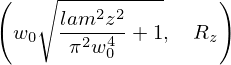

In [335]:
w, R_z,

In [47]:
temp = '-4.86300745 -4.8881506 -4.91442598 -4.94181552 -4.9703008  -4.99986309   -5.03048341   -5.06214255 -5.09482116 -5.12849974'.split(' ')
temp = np.array([np.float(i) for i in temp if len(i)>0])
temp

array([-4.86300745, -4.8881506 , -4.91442598, -4.94181552, -4.9703008 ,
       -4.99986309, -5.03048341, -5.06214255, -5.09482116, -5.12849974])

In [188]:
temp0 = np.array([0, 2, 3])
temp1 = np.array([1, 5, 3])
temp2 = np.array([1, 2, 10])

temp = np.array([temp0, temp1, temp2])
temp.max(), temp.flatten()

(10, array([ 0,  2,  3,  1,  5,  3,  1,  2, 10]))

In [275]:
np.linspace(400, 500, 10), np.arange(400, 510, 10)

(array([400.        , 411.11111111, 422.22222222, 433.33333333,
        444.44444444, 455.55555556, 466.66666667, 477.77777778,
        488.88888889, 500.        ]),
 array([400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]))

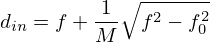

In [538]:
eq_din_p

In [551]:
eq_din_p.subs({M:0.15/0.3, f0:1.88626052, f:7.16841458}), eq_din_p.subs({M:0.15/0.3, f0:1.88626052, f:-21.16841458})

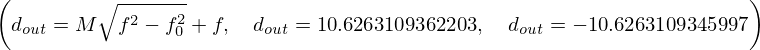

In [560]:
eq_dout_p, eq_dout_p.subs({M:0.15/0.3, f0:1.88626052, f:7.16841458}), eq_dout_p.subs({M:0.15/0.3, f0:1.88626052, f:-21.16841458})

In [488]:
temp = np.array([-1, -2, -3])
temp.max()

-1

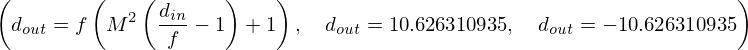

In [569]:
eq_dout2 = Eq(d_out, f*(1+(M**2*(d_in/f - 1))))
eq_dout2, eq_dout2.subs({M:0.15/0.3, f:7.16841458, d_in:21}), eq_dout2.subs({M:0.15/0.3, f:-21.16841458, d_in:21})

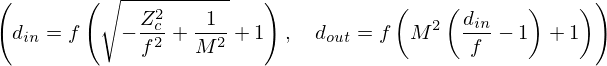

In [653]:
eq_dout2 = Eq(d_out, f*(1+(M**2*(d_in/f - 1))))
eq_din2 = Eq(d_in, f*(1+sqrt(M**-2-(Z_c/f)**2)))
eq_din2, eq_dout2

In [ ]:
zr = z_r.subs({w0:0.34, lam:ghz_cm(402.8)}).evalf()
f1.subs({d_in:18, Z_c:zr}), 

In [ ]:
fm.subs({d_in:18, Z_c:zr, E:1-(0.15/0.34)**-2}), fp.subs({d_in:18, Z_c:zr, E:1-(0.15/0.34)**-2})

In [ ]:
eq_din_m, eq_din_p, eq_din_p.subs({M:0.5, f0:1.53258667, f:7.2}), eq_din_m.subs({M:0.5, f0:1.53258667, f:-7.2})

In [ ]:
eq_dout_m, eq_dout_p, eq_dout_p.subs({M:0.22, f0:2.28237523, f:-6.45743983}), eq_dout_p.subs({M:0.22, f0:2.28237523, f:4.32})

In [ ]:
fm, fp, f1, z_r

In [ ]:
np.cos(90), np.cos(np.pi/2), np.cos(np.deg2rad(90))

In [ ]:
e_ellipsoid

In [ ]:
np.degrees(np.arctan(1)), np.tan(np.deg2rad(45))

In [ ]:
f_ellipsoid.simplify()

In [ ]:
eq_radiusOfCurvature.rhs